In [2]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

_default_date_format = "%Y-%m-%d"

In [5]:
def date_to_int(date_string: str, form: str=_default_date_format) -> int:
    """Return date date_string in format form as an integer"""
    return dt.datetime.strptime(date_string, form).toordinal()

def int_to_date(ordinal: int, form: str=_default_date_format) -> str:
    """Return the day number ordinal to as a string, formatted with form"""
    return dt.datetime.fromordinal(ordinal).strftime(form)

def add_lag(df, feature_dict, trim=True):
    """Add columns for lag variables"""
    series_list = []
    for feature in feature_dict.keys():
        for n in feature_dict[feature]:
            if n != 0:
                series = df[feature].shift(n).copy().rename(feature+str(n))
                series_list.append(series) 
    untrimmed = pd.concat([df[feature_dict.keys()]] + series_list, axis=1).copy()
    if trim:
        return untrimmed.iloc[max(np.max(feature_dict[feature]) \
                                  for feature in feature_dict \
                                 if len(feature_dict[feature]) > 0):]
    else:
        return untrimmed

In [9]:
covid = pd.read_csv("../../data/input/covid_data.csv")
covid_state = {}
state_dir = join("..", "..", "..", "states")
for filename in listdir(state_dir):
    if filename[-4:] == ".csv":
        covid_state[filename[:-4]] = pd.read_csv(join(state_dir, filename))
state_list = list(covid_state.keys())

covid_state_train = {}
covid_state_holdout = {}
for state in state_list:
    selector = (covid_state[state].day_number <= date_to_int("2021-07-31")) & \
            (covid_state[state].day_number >= date_to_int("2020-08-01"))
    covid_state_train[state] = covid_state[state].loc[selector].copy()
    selector = (covid_state[state].day_number <= date_to_int("2021-08-31")) & \
            (covid_state[state].day_number >= date_to_int("2021-08-01"))
    covid_state_holdout[state] = covid_state[state].loc[selector].copy()
    
selector = (covid.day_number <= date_to_int("2021-07-31")) & \
            (covid.day_number >= date_to_int("2020-08-01"))

covid_train = covid.loc[selector].copy()
selector = (covid.day_number <= date_to_int("2021-08-31")) & \
            (covid.day_number >= date_to_int("2021-08-01"))
covid_holdout = covid.loc[selector].copy()

def transform(df, lag=None):
    """ Extract a few columns and add lag variables """
    df_new = pd.DataFrame(index=df.index, columns=["date", "day", "state",
                                                   "cases","hosp", "deaths",
                                                   "beds", "vacc"])
    df_new.date = df.date.copy()
    df_new.day = df.day_number.copy()
    df_new.state = df.state.copy()
    df_new.cases = df.new_case.copy()
    df_new.hosp = df.previous_day_admission_adult_covid_confirmed + \
              df.previous_day_admission_adult_covid_suspected
    df_new.deaths = df.new_death.copy()
    df_new.beds = df.inpatient_beds_used_covid.copy()
    df_new.vacc = df.Administered
    if lag is not None:
        return add_lag(df_new,{feature: range(1,lag+1) for feature in df_new.columns})
    return df_new

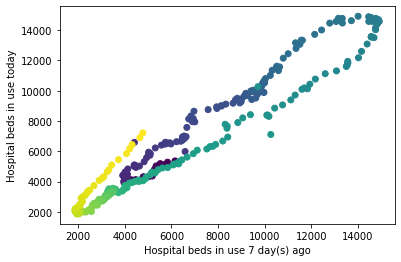

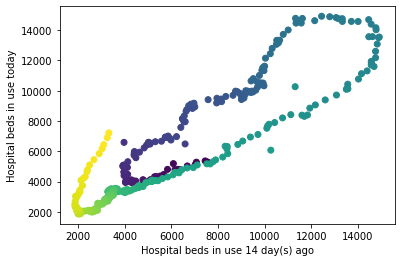

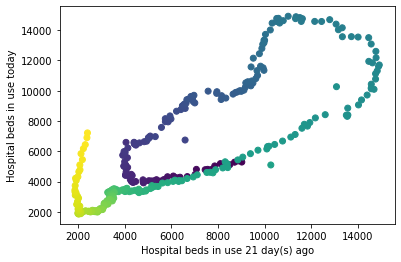

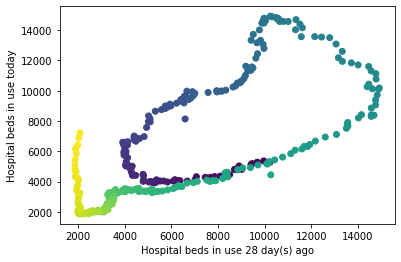

In [10]:
# Plot hospital beds occupied in given state by covid patients n days ago
# vs today, for various values on n

state = "TX"
df = transform(covid_state_train[state], 30)
for n in range(7,30,7):
    plt.scatter(df[f"beds{n}"], df["beds"], c=df.day)
    plt.xlabel(f"Hospital beds in use {n} day(s) ago")
    plt.ylabel("Hospital beds in use today")
    plt.show()

WV


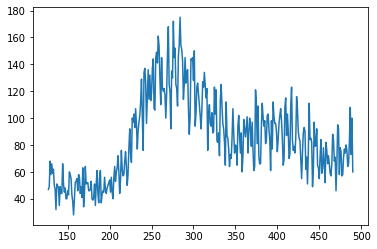

VA


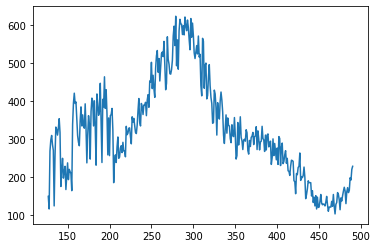

IA


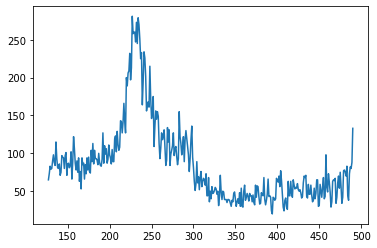

In [24]:
# Graphs of hospitalizations in three states
for state in state_list[:3]:
    df = transform(covid_state_train[state], 1)
    print(state)
    plt.plot(df.hosp)
    plt.show()

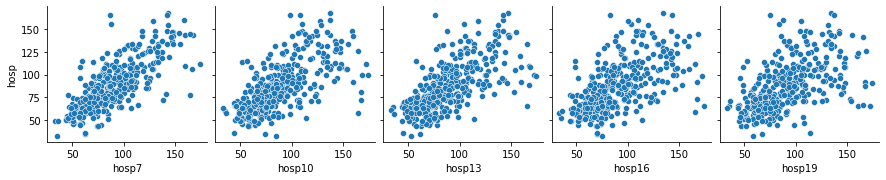

In [242]:
# Hospitalizations some days ago vs hospitalizations today
sns.pairplot(transform(covid_state_train["OR"], 20),
            y_vars="hosp",
            x_vars=[f"hosp{n}" for n in [7,10,13,16,19]])

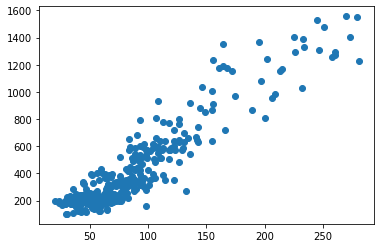

In [25]:
# New hospitalizations for covid vs covid beds in use
plt.scatter(df.hosp, df.beds)
plt.show()

In [104]:
features = ["inpatient_beds_used_covid",
"percent_of_inpatients_with_covid",
"deaths_covid",
"tot_cases",
"new_case",
"pnew_case",
"tot_death",
"new_death",
"pnew_death",
 "Distributed",
           "state"]
covid_slim = covid_train[features]

<AxesSubplot:xlabel='new_case', ylabel='tot_cases'>

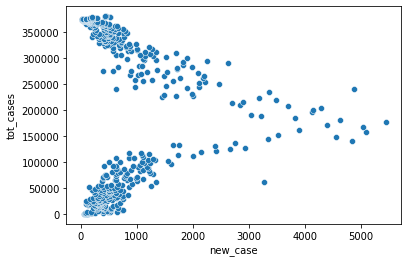

In [102]:
sns.scatterplot(x=covid_lag_state["IA"].new_case, y=covid_lag_state["IA"].tot_cases)

In [147]:
lag_list = range(1,121)
covid_lag = add_lag(covid_slim, {"new_case": lag_list,
                                 "inpatient_beds_used_covid": [],
                                "state": []}).copy()

covid_lag_state = {state: covid_lag.loc[covid_lag.state == state]
                      for state in state_list}

In [113]:
state = "KS"
df = covid_lag_state[state]
corr_list = [np.corrcoef(df[f"new_case{n}"], df.inpatient_beds_used_covid)[0,1] for n in range(1,31)]
M = np.argmax(corr_list)
print(state, M, corr_list[M-1:M+2])

KS 0 []


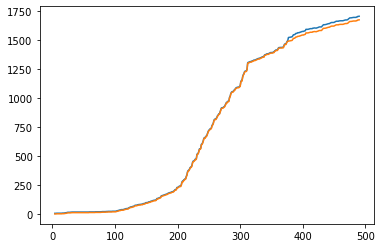

In [212]:
plt.plot(df.tot_death)
plt.plot(np.cumsum(df.new_death))

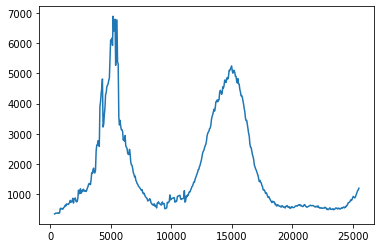

In [151]:
plt.plot(df.inpatient_beds_used_covid)

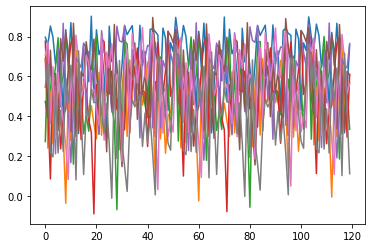

In [148]:
import random
random.shuffle(state_list)
for state in state_list[:8]:
    df = covid_lag_state[state]
    corr_list = [np.corrcoef(df[f"new_case{n}"], df.inpatient_beds_used_covid)[0,1] for n in range(1,121)]
    M = np.argmax(corr_list)
    plt.plot(corr_list)
plt.show()

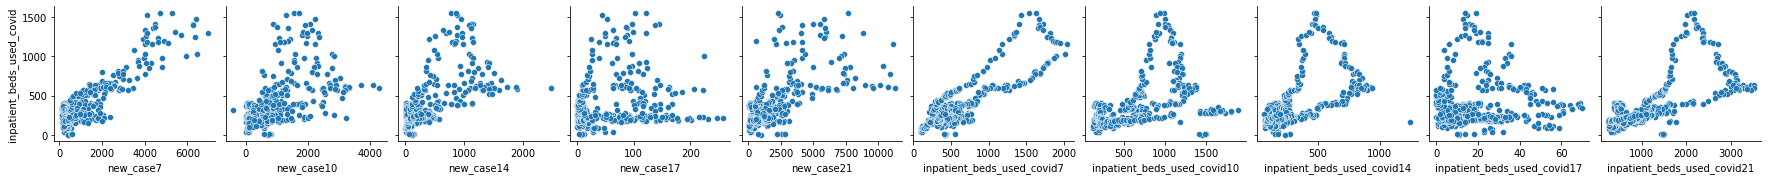

In [99]:
sns.pairplot(covid_lag_state["IA"], y_va
             rs="inpatient_beds_used_covid",
            x_vars=[f"new_case{n}" for n in lag_list] + \
                    [f"inpatient_beds_used_covid{n}" for n in lag_list])

In [77]:
for index in covid_train.index:
    if np.isnan(covid_train.inpatient_beds_utilization[index]):
        print(index)

In [78]:
covid_train

,day_number,date,state,critical_staffing_shortage_today_yes,critical_staffing_shortage_today_no,critical_staffing_shortage_today_not_reported,critical_staffing_shortage_anticipated_within_week_yes,critical_staffing_shortage_anticipated_within_week_no,critical_staffing_shortage_anticipated_within_week_not_reported,hospital_onset_covid,...,Additional_Doses_18Plus,Additional_Doses_18Plus_Vax_Pct,Additional_Doses_50Plus,Additional_Doses_50Plus_Vax_Pct,Additional_Doses_65Plus,Additional_Doses_65Plus_Vax_Pct,Additional_Doses_Moderna,Additional_Doses_Pfizer,Additional_Doses_Janssen,Additional_Doses_Unk_Manuf
208,737516,2020-04-01,AK,0,0,14,0,0,14,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
209,737516,2020-04-01,AL,0,0,45,0,0,45,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
210,737516,2020-04-01,AR,0,0,39,0,0,39,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
211,737516,2020-04-01,AZ,0,0,37,0,0,37,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
212,737516,2020-04-01,CA,0,0,138,0,0,138,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25527,738002,2021-07-31,VT,1,15,1,1,15,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25528,738002,2021-07-31,WA,10,93,2,10,93,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25529,738002,2021-07-31,WI,8,118,24,13,113,24,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25530,738002,2021-07-31,WV,13,46,4,12,47,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
covid.loc[163]

day_number                                  737515
date                                    2020-03-31
state                                           DC
critical_staffing_shortage_today_yes             0
critical_staffing_shortage_today_no              0
                                           ...    
Additional_Doses_65Plus_Vax_Pct                0.0
Additional_Doses_Moderna                       0.0
Additional_Doses_Pfizer                        0.0
Additional_Doses_Janssen                       0.0
Additional_Doses_Unk_Manuf                     0.0
Name: 163, Length: 191, dtype: object

In [40]:
date_list = []
for index in covid.index:
    if np.isnan(covid["total_adult_patients_hospitalized_confirmed_and_suspected_covid"][index]):
        date = covid["date"][index]
        if len(date_list) == 0 or date != date_list[-1]:
            date_list.append(date)

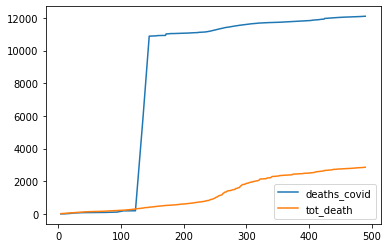

In [181]:
df = covid_state_train["OR"]
plt.plot(np.cumsum(df.deaths_covid),label="deaths_covid")
plt.plot(df.tot_death,label="tot_death")
plt.legend()
plt.show()

In [203]:
# np.diff(df.tot_death)  looks good
np.diff([2,4,7,6])

array([ 2,  3, -1])

In [202]:
for state in "OK OR ME TX CA MT".split():
    df = covid_state_train[state]
    print(f"{state}:",df.tot_death.iloc[-1])

OK: 7515
OR: 2859
ME: 900
TX: 52085
CA: 64303
MT: 1705


4855.0

In [ ]:
np.cumsum(df.deaths_covid)

In [171]:
sum(df.deaths_covid)
# deaths_covid counts only hospital deaths, not all deaths
# nope, that doesn't explain it

12099.0

In [176]:
df.prob_death

AttributeError: 'DataFrame' object has no attribute 'prob_death'

In [174]:
df.tot_death

4        18
5        21
6        22
7        26
8        27
       ... 
486    2843
487    2849
488    2855
489    2858
490    2859
Name: tot_death, Length: 487, dtype: int64

In [169]:
np.diff(df.tot_death)

array([ 3,  1,  4,  1,  2,  4,  5,  6,  4,  3,  1,  1,  2,  3,  6,  6,  2,
        2,  1,  3,  0,  5,  3,  1,  4,  1,  7,  2,  2,  1,  5,  0,  0,  4,
        2,  6,  3,  3,  0,  3,  0,  4,  3,  0,  0,  0,  1,  2,  4,  1,  2,
        0,  1,  0,  0,  0,  3,  0,  2,  0,  1,  3,  2,  0,  2,  2,  1,  0,
        5,  0,  2,  2,  1,  2,  4,  2,  1,  4,  1,  1,  1,  2,  0,  3,  2,
        5,  0,  0,  2,  3,  1,  1,  0,  4,  2,  0,  5,  4,  6,  2,  0,  2,
        3,  7,  3,  2,  5,  3,  3,  2,  7,  2,  2,  9,  4,  3,  0, 14,  8,
        5,  6,  3,  1,  2,  5,  5,  1,  9,  7,  1,  1, 11,  7,  8,  2,  1,
        7,  3,  1, 11,  4,  2,  3,  0,  3,  8,  5,  5,  9,  7,  4,  1,  6,
        3,  2,  5,  5,  1,  1,  4,  8,  3,  2,  6,  4,  2,  8,  2,  0,  0,
        4,  1,  3,  3,  6,  1,  3,  4,  1,  0,  8,  4,  1,  3,  8,  1,  0,
        9,  2, 11,  3,  0,  2,  0,  6,  3,  3,  6,  3,  0,  8,  5,  2, 11,
        3,  0,  4,  2,  9,  7,  2,  2, 14,  2,  1,  9,  4,  5,  6, 13,  1,
        4,  3,  5,  4,  7

In [162]:
covid.deaths_covid

0         0.0
1         0.0
2         0.0
3         0.0
4         4.0
         ... 
29583     1.0
29584    14.0
29585    21.0
29586    19.0
29587     2.0
Name: deaths_covid, Length: 29588, dtype: float64

In [158]:
covid.tot_cases
covid.deaths_covid - covid.tot_death

0          -4.0
1         -27.0
2          -5.0
3         -15.0
4        -387.0
          ...  
29583    -326.0
29584   -8220.0
29585   -9141.0
29586   -4089.0
29587   -1078.0
Length: 29588, dtype: float64

In [65]:
covid["previous_day_admission_adult_covid_confirmed_20-29_coverage"][12346:12346+10]

12554    160
12555    130
12556    126
12557     99
12558     66
12559    121
12560     47
12561    100
12562     29
12563     79
Name: previous_day_admission_adult_covid_confirmed_20-29_coverage, dtype: int64

In [70]:
sum(covid["previous_day_admission_adult_covid_confirmed_30-39_coverage"] !=\
    covid["previous_day_admission_adult_covid_confirmed_40-49_coverage"])

3421

In [71]:
columns = covid.columns
for column in columns:
    if "coverage" in column:
        continue
    isna = covid[column].isna()
    S = sum(isna)
    if S ==0:
        print(column)

day_number
date
state
critical_staffing_shortage_today_yes
critical_staffing_shortage_today_no
critical_staffing_shortage_today_not_reported
critical_staffing_shortage_anticipated_within_week_yes
critical_staffing_shortage_anticipated_within_week_no
critical_staffing_shortage_anticipated_within_week_not_reported
hospital_onset_covid
inpatient_beds
inpatient_beds_used
inpatient_beds_used_covid
inpatient_beds_utilization
inpatient_beds_utilization_numerator
inpatient_beds_utilization_denominator
percent_of_inpatients_with_covid
percent_of_inpatients_with_covid_numerator
percent_of_inpatients_with_covid_denominator
inpatient_bed_covid_utilization
inpatient_bed_covid_utilization_numerator
inpatient_bed_covid_utilization_denominator
tot_cases
new_case
tot_death
new_death
created_at
MMWR_week
Distributed
Distributed_Janssen
Distributed_Moderna
Distributed_Pfizer
Distributed_Unk_Manuf
Dist_Per_100K
Distributed_Per_100k_12Plus
Distributed_Per_100k_18Plus
Distributed_Per_100k_65Plus
Administere

In [45]:
columns = covid.columns
for column in columns:
    isna = covid[column].isna()
    S = sum(isna)
    if S > 0:
        print(column, S)
        if S < 10:
            print([index for index in covid.index if np.isnan(covid[column][index])])

previous_day_admission_adult_covid_confirmed 4838
previous_day_admission_adult_covid_suspected 4976
previous_day_admission_pediatric_covid_confirmed 5231
previous_day_admission_pediatric_covid_suspected 5221
staffed_adult_icu_bed_occupancy 5230
staffed_icu_adult_patients_confirmed_and_suspected_covid 5163
staffed_icu_adult_patients_confirmed_covid 5013
total_adult_patients_hospitalized_confirmed_and_suspected_covid 4659
total_adult_patients_hospitalized_confirmed_covid 4569
total_pediatric_patients_hospitalized_confirmed_and_suspected_covid 5228
total_pediatric_patients_hospitalized_confirmed_covid 5228
total_staffed_adult_icu_beds 5050
adult_icu_bed_covid_utilization 5521
adult_icu_bed_covid_utilization_coverage 5231
adult_icu_bed_covid_utilization_numerator 5231
adult_icu_bed_covid_utilization_denominator 5231
adult_icu_bed_utilization 5506
adult_icu_bed_utilization_coverage 5230
adult_icu_bed_utilization_numerator 5230
adult_icu_bed_utilization_denominator 5230
previous_day_admissio